## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import cv2
import os

## Preparar os dados

In [2]:
# Configurações gerais
R = 50  # Redimensionamento das imagens
base_path = "../data/RecFac"

In [3]:
name_list = os.listdir(base_path)
C = len(name_list)  # Número de classes
X = np.empty((R*R, 0))  # Dados p x N
Y = np.empty((C, 0))    # Rótulos one-hot C x N

for i, nome in enumerate(name_list):
    lista_imagens = os.listdir(f"{base_path}\\{nome}")
    
    # Criação do vetor one-hot
    rotulo = -np.ones((C, len(lista_imagens)))
    rotulo[i, :] = 1
    Y = np.hstack((Y, rotulo))
    
    # Processamento das imagens
    for imagem in lista_imagens:
        img = cv2.imread(f"{base_path}\\{nome}\\{imagem}", cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (R, R))
        x = img.flatten().reshape(img.size, 1)
        X = np.hstack((X, x))

# Normalização dos dados entre 0 e 1
X = (X - np.min(X)) / (np.max(X) - np.min(X))
print(f"X: {X.shape}, Y: {Y.shape}")
name_list = os.listdir(base_path)
C = len(name_list)  # Número de classes
X = np.empty((R*R, 0))  # Dados p x N
Y = np.empty((C, 0))    # Rótulos one-hot C x N

for i, nome in enumerate(name_list):
    lista_imagens = os.listdir(f"{base_path}\\{nome}")
    
    # Criação do vetor one-hot
    rotulo = -np.ones((C, len(lista_imagens)))
    rotulo[i, :] = 1
    Y = np.hstack((Y, rotulo))
    
    # Processamento das imagens
    for imagem in lista_imagens:
        img = cv2.imread(f"{base_path}\\{nome}\\{imagem}", cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (R, R))
        x = img.flatten().reshape(img.size, 1)
        X = np.hstack((X, x))

# Normalização dos dados entre 0 e 1
X = (X - np.min(X)) / (np.max(X) - np.min(X))
print(f"X: {X.shape}, Y: {Y.shape}")

X: (2500, 640), Y: (20, 640)
X: (2500, 640), Y: (20, 640)


## Funções auxiliares

In [38]:
# Função para calcular acurácia
def accuracy(y_true, y_pred):
    pred_class = np.argmax(y_pred, axis=0)
    true_class = np.argmax(y_true, axis=0)
    return np.mean(pred_class == true_class)

def confusion_matrix_labels(y_true, y_pred, num_classes=None):
    if num_classes is None:
        num_classes = int(max(y_true.max(), y_pred.max()) + 1)

    cm = np.zeros((num_classes, num_classes), dtype=float)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    # Normaliza cada linha, evitando divisão por zero
    with np.errstate(divide='ignore', invalid='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, row_sums, where=row_sums != 0) * 100

    return np.nan_to_num(cm)  # substitui NaN por 0


def plot_confusion_matrices(cm_max, cm_min, title_max='Maior Acurácia', title_min='Menor Acurácia'):
    labels = [f"C{i}" for i in range(cm_max.shape[0])]  # nomes das classes (ex: C0, C1, C2...)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.set(font_scale=0.9)
    sns.set_style("whitegrid")

    # --- Maior acurácia ---
    sns.heatmap(cm_max, annot=True, fmt=".1f", cmap="crest",
                xticklabels=labels, yticklabels=labels,
                square=True, cbar=False, linewidths=0.5, ax=axes[0])
    axes[0].set_title(f'Matriz de Confusão (%) - {title_max}', fontsize=13, pad=12)
    axes[0].set_xlabel('Classe Predita')
    axes[0].set_ylabel('Classe Verdadeira')

    # --- Menor acurácia ---
    sns.heatmap(cm_min, annot=True, fmt=".1f", cmap="rocket_r",
                xticklabels=labels, yticklabels=labels,
                square=True, cbar=False, linewidths=0.5, ax=axes[1])
    axes[1].set_title(f'Matriz de Confusão (%) - {title_min}', fontsize=13, pad=12)
    axes[1].set_xlabel('Classe Predita')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [5]:
def monte_carlo_split(X, Y, train_ratio=0.8):
    N = X.shape[1]
    idx = np.random.permutation(N)
    train_size = int(train_ratio * N)
    train_idx = idx[:train_size]
    test_idx = idx[train_size:]
    return X[:, train_idx], Y[:, train_idx], X[:, test_idx], Y[:, test_idx]


## Classes

In [ ]:
class Perceptron:
    def __init__(self, X_train, y_train, learning_rate=1e-3, plot=True, max_epochs=1000):
        self.p, self.N = X_train.shape
        self.X_train = np.vstack((
            -np.ones((1, self.N)), X_train
        ))
        self.d = y_train
        self.lr = learning_rate
        self.w = np.random.random_sample((self.p+1,1)) - 0.5
        self.plot = plot
        self.max_epochs = max_epochs
        self.x1 = np.linspace(-2, 10)
        
        if plot:
            self.fig = plt.figure(1)
            self.ax = self.fig.add_subplot()
            self.ax.scatter(self.X_train[1, self.d[:]==1],
                            self.X_train[2, self.d[:]==1], marker='s', s=120)
            self.ax.scatter(self.X_train[1, self.d[:]==-1],
                            self.X_train[2, self.d[:]==-1], marker='o', s=120)
            self.ax.set_xlim(-1, 7)
            self.ax.set_ylim(-1, 7)
            self.draw_line()
        
    def draw_line(self, c='k', alpha=1, lw=2):
        x2 = -self.w[1,0]/self.w[2,0]*self.x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        if self.plot:
            plt.plot(self.x1, x2, c=c, alpha=alpha, lw=lw)
        
    def activation_function(self, u):
        return 1 if u >= 0 else -1
    
    def fit(self):
        epochs = 0
        error = True
        while error and epochs < self.max_epochs:
            error = False
            for k in range(self.N):
                x_k = self.X_train[:, k].reshape(self.p+1, 1)
                u_k = (self.w.T @ x_k)[0,0]
                y_k = self.activation_function(u_k)
                d_k = self.d[k]
                e_k = d_k - y_k
                if e_k != 0:
                    error = True
                self.w = self.w + self.lr * e_k * x_k
            
            if self.plot:
                plt.pause(.4)
                self.draw_line(c='r', alpha=.5)
            epochs += 1
        
        if self.plot:
            plt.pause(.4)
            self.draw_line(c='g', alpha=1, lw=4)
            plt.show()
            
        if epochs == self.max_epochs:
            misclassified = [k for k in range(self.N) 
            if self.activation_function((self.w.T @ self.X_train[:, k].reshape(self.p+1,1))[0,0]) != self.d[k]]
            print(f'Treinamento interrompido após {epochs} épocas (não convergiu completamente).')
            print("Índices dos exemplos incorretos:", misclassified)
            print("Pesos finais:", self.w.ravel())

    def predict(self, X):
        N = X.shape[1]
        y_pred = np.zeros(N)
        for i in range(N):
            x_i = np.vstack((-np.ones((1,1)), X[:,i].reshape(-1,1)))
            y_pred[i] = self.activation_function((self.w.T @ x_i)[0,0])
        return y_pred

In [7]:
class MultilayerPerceptron:
    def __init__(self,X_train:np.ndarray, Y_train:np.ndarray, topology:list, learning_rate = 1e-3, max_epoch=10000, tol = 1e-12):
        '''
        X_train (p x N)
        Y_train (C x N) ou (1 x N) se classificação binária
        '''
        self.p , self.N = X_train.shape
        self.m = Y_train.shape[0]
        
        self.X_train = np.vstack((
            -np.ones((1,self.N)),X_train
        ))
        self.tol = tol
        self.lr = learning_rate
        self.d = Y_train
        topology.append(self.m)
        self.W = [None]*len(topology)
        Z = 0
        for i in range(len(self.W)):
            if i == 0:
                W = np.random.random_sample((topology[i],self.p+1))-.5
            else:
                W = np.random.random_sample((topology[i],topology[i-1]+1))-.5
            self.W[i] = W
            Z += W.size
        print(f"Rede MLP com {Z} parâmetros")
        self.max_epoch = max_epoch
        self.y = [None]*len(topology)
        self.u = [None]*len(topology)
        self.delta = [None]*len(topology)
        
    def g(self, u):
        return (1-np.exp(-u))/(1+np.exp(-u))
    
    def g_d(self, u):
        y = self.g(u)
        return .5*(1-y**2)
    
    def backward(self, e,x):
        for i in range(len(self.W)-1,-1,-1):
            if i == len(self.W)-1:
                self.delta[i] = self.g_d(self.u[i]) * e
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            elif i == 0:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@x.T)
                
            else:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            
    
    def forward(self, x):
        
        for i,W in enumerate(self.W):
            if i == 0:
                self.u[i] = W@x
            else:
                yb = np.vstack((
                    -np.ones((1,1)), self.y[i-1]
                ))
                self.u[i] = W@yb                
            self.y[i] = self.g(self.u[i])
         
        
        
    def EQM(self):
        s = 0
        for k in range(self.N):
            x_k = self.X_train[:,k].reshape(self.p+1,1)
            self.forward(x_k)
            y = self.y[-1]
            d = self.d[:,k].reshape(self.m,1)
            e = d - y
            s += np.sum(e**2)
        return s/(2*self.N)
        
    def fit(self):
        epoch = 0
        EQM1 = 1
        self.history = []
        
        while epoch < self.max_epoch and EQM1>self.tol:
            t1 = time()
            for k in range(self.N):
                x_k = self.X_train[:,k].reshape(self.p+1,1)
                #Forward
                self.forward(x_k)
                y = self.y[-1]
                d = self.d[:,k].reshape(self.m,1)
                e = d - y
                #Backward
                self.backward(e,x_k)
            t2 = time()
            EQM1 = self.EQM()
            self.history.append(EQM1)
            epoch+=1
            # print(f"Tempo: {t2-t1:.5f}s  Época: {epoch}, EQM: {EQM1:.15f}")

    def predict(self, X):
        """
        Faz a predição para novos dados X (p x N_test)
        Retorna uma matriz de saída (m x N_test)
        """
        N_test = X.shape[1]

        X_bias = np.vstack((-np.ones((1, N_test)), X))
        
        Y_pred = np.zeros((self.m, N_test))
        
        for k in range(N_test):
            x_k = X_bias[:, k].reshape(self.p+1, 1)
            self.forward(x_k)
            Y_pred[:, k] = self.y[-1][:, 0]
        
        return Y_pred


## Treinamentos

### Treinamento do Perceptron Simples

In [8]:
# Lista para armazenar resultados
R_simulations = 10
acc_perceptron = []

for r in range(R_simulations):
    X_train, Y_train, X_test, Y_test = monte_carlo_split(X, Y)
    results_class = []
    for c in range(Y.shape[0]):
        perc = Perceptron(X_train, Y_train[c, :], learning_rate=0.001, plot=False)
        perc.fit()
        # Previsão
        y_pred = np.array([perc.activation_function(perc.w.T @ np.vstack((-1, X_test[:, k].reshape(-1,1)))) 
                           for k in range(X_test.shape[1])])
        # Converter -1/1 para 0/1
        y_pred_bin = np.where(y_pred==1, 1, -1)
        results_class.append(y_pred_bin.reshape(1, -1))
    
    print(f"Simulação {r+1}/{R_simulations} concluída.")
    y_pred_all = np.vstack(results_class)
    acc = accuracy(Y_test, y_pred_all)
    acc_perceptron.append(acc)

print("Acurácia média Perceptron:", np.mean(acc_perceptron))

Treinamento concluído em 31 épocas.
Treinamento concluído em 28 épocas.
Treinamento concluído em 19 épocas.
Treinamento concluído em 18 épocas.
Treinamento concluído em 20 épocas.
Treinamento concluído em 16 épocas.
Treinamento concluído em 57 épocas.
Treinamento concluído em 19 épocas.
Treinamento concluído em 36 épocas.
Treinamento concluído em 13 épocas.
Treinamento concluído em 17 épocas.
Treinamento concluído em 19 épocas.
Treinamento concluído em 51 épocas.
Treinamento concluído em 31 épocas.
Treinamento concluído em 17 épocas.
Treinamento concluído em 20 épocas.
Treinamento concluído em 14 épocas.
Treinamento concluído em 13 épocas.
Treinamento concluído em 17 épocas.
Treinamento concluído em 19 épocas.
Simulação 1/10 concluída.
Treinamento concluído em 21 épocas.
Treinamento concluído em 44 épocas.
Treinamento concluído em 19 épocas.
Treinamento concluído em 49 épocas.
Treinamento concluído em 17 épocas.
Treinamento concluído em 27 épocas.
Treinamento concluído em 20 épocas.
Tr

### Treinamento do MLP

In [14]:
acc_mlp = []
histories = []
splits = []

for r in range(R_simulations):
    X_train, Y_train, X_test, Y_test = monte_carlo_split(X, Y)
    
    # Topologia: 1 camada oculta com 50 neurônios
    mlp = MultilayerPerceptron(X_train, Y_train, topology=[50], learning_rate=0.001, max_epoch=500)
    mlp.fit()
    
    # Previsão
    Y_pred = mlp.predict(X_test)
    acc = accuracy(Y_test, Y_pred)
    
    acc_mlp.append(acc)
    histories.append(mlp.history)
    splits.append((X_train, Y_train, X_test, Y_test, mlp))

print("Acurácia média MLP:", np.mean(acc_mlp))

Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Rede MLP com 126070 parâmetros
Acurácia média MLP: 0.98203125


In [22]:
idx_max = np.argmax(acc_mlp)
print(splits[idx_max])

print(type(splits))
print(len(splits))
print(splits[0])


(array([[0.3625498 , 0.01992032, 0.32669323, ..., 0.37450199, 0.40239044,
        0.23904382],
       [0.39840637, 0.01992032, 0.31474104, ..., 0.4063745 , 0.42629482,
        0.26294821],
       [0.3625498 , 0.01992032, 0.30278884, ..., 0.36653386, 0.39442231,
        0.23904382],
       ...,
       [0.        , 0.09561753, 0.18326693, ..., 0.        , 0.00398406,
        0.        ],
       [0.        , 0.        , 0.01593625, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(2500, 512)), array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], shape=(20, 512)), array([[0.07968127, 0.20318725, 0.12749004, ..., 0.24701195, 0.35856574,
        0.24302789],
       [0.071

## Resultados

cm_max:
 [[100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         100.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.         100.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         100.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.     

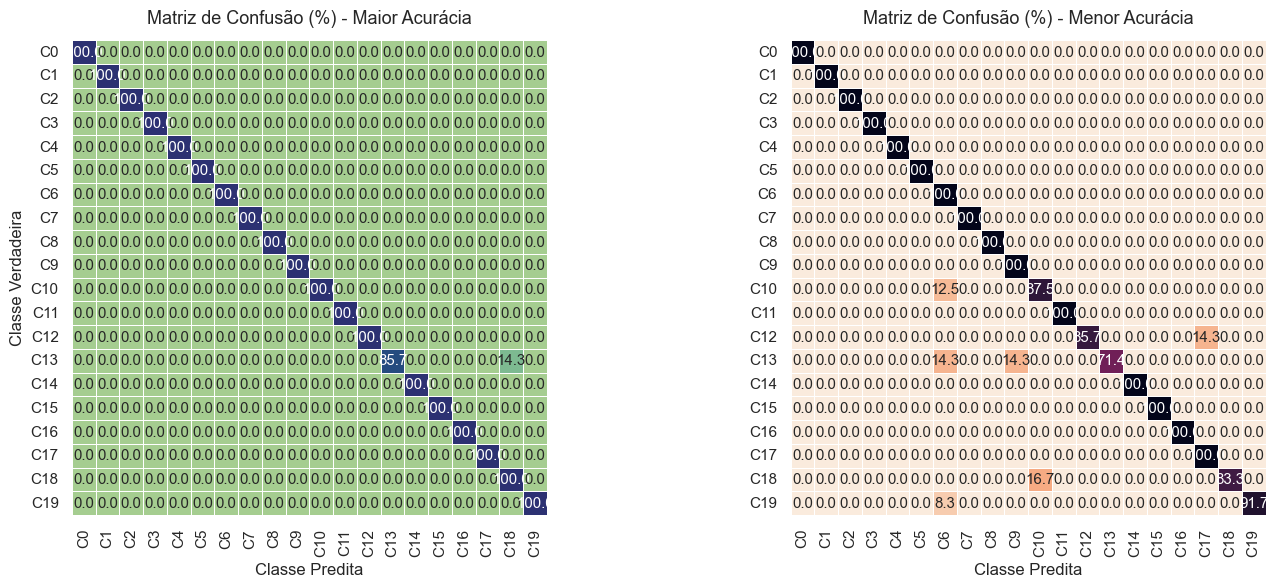

In [39]:

# Índices de maior e menor acurácia
idx_max = int(np.argmax(acc_mlp))
idx_min = int(np.argmin(acc_mlp))

# Recupera dados e modelo correspondentes
_, _, X_test_max, Y_test_max, mlp_max = splits[idx_max]
_, _, X_test_min, Y_test_min, mlp_min = splits[idx_min]

# Predições
Y_pred_max = mlp_max.predict(X_test_max)
Y_pred_min = mlp_min.predict(X_test_min)

# Tratamento para classificação binária OU multiclasse
if Y_test_max.ndim == 1 or Y_test_max.shape[0] == 1:
    # Binária
    Y_true_max = (Y_test_max.flatten() > 0.5).astype(int)
    Y_hat_max = (Y_pred_max.flatten() > 0).astype(int)

    Y_true_min = (Y_test_min.flatten() > 0.5).astype(int)
    Y_hat_min = (Y_pred_min.flatten() > 0).astype(int)
else:
    # Multiclasse
    Y_true_max = np.argmax(Y_test_max, axis=0)
    Y_hat_max = np.argmax(Y_pred_max, axis=0)

    Y_true_min = np.argmax(Y_test_min, axis=0)
    Y_hat_min = np.argmax(Y_pred_min, axis=0)

# Matrizes de confusão
cm_max = confusion_matrix_labels(Y_true_max, Y_hat_max)
cm_min = confusion_matrix_labels(Y_true_min, Y_hat_min)

print("cm_max:\n", cm_max)
print("cm_min:\n", cm_min)
print("Somas por linha (max):", cm_max.sum(axis=1))
print("Somas por linha (min):", cm_min.sum(axis=1))


plot_confusion_matrices(cm_max, cm_min)

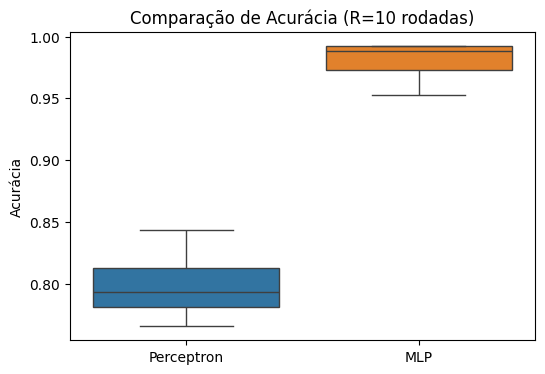

In [33]:
plt.figure(figsize=(6,4))
sns.boxplot(data=[acc_perceptron, acc_mlp])
plt.xticks([0,1], ['Perceptron', 'MLP'])
plt.ylabel("Acurácia")
plt.title("Comparação de Acurácia (R=10 rodadas)")
plt.show()
